# 7506 - Trabajo Práctico 2

---

## Introducción

### Librerías

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.metrics import *
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
from matplotlib import style
from joblib import load
import sklearn as sk

In [54]:
# Dataset Train preprocesado
ds_train = pd.read_csv('datasets/tp1-train_id.csv')
ds_train = ds_train.drop(['Unnamed: 0'], axis=1)
ds_train.head()

,id,start_date,end_date,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title
0,AkvIZkI7XvbCQ/Z7zZ7lXw==,2021-07-29,2021-09-06 00:00:00.000000000,-34.564800,-58.444631,Belgrano,Departamento,5.0,4.0,279.0,245.0,1000000.0,Espectacular torre en la mejor zona de Belgran...
1,fPYqaGC1CO4tGa5Lfbsfxw==,2021-12-16,2022-02-09 00:00:00.000000000,-34.591359,-58.418809,Palermo,Departamento,2.0,1.0,42.0,42.0,89900.0,VENTA 2 AMBIENTES RECICLADO - PALERMO
2,iEf87GrVMz/FhIPsQTns4w==,2021-06-19,2021-09-01 15:14:13.531306906,-34.602632,-58.428399,Almagro,Departamento,2.0,1.0,46.0,42.0,119900.0,2 ambientes al frente con balcón. A estrenar.
3,po58pOgih96xIX9iBLCejA==,2021-12-16,2022-02-09 00:00:00.000000000,-34.564290,-58.439272,Palermo,Departamento,3.0,2.0,69.0,58.0,175000.0,DEPARTAMENTO 3 Ambientes Palermo-Balcón C/Parr...
4,GNPH2InKGIZ3mGgnJGK9HQ==,2021-12-16,2022-02-09 00:00:00.000000000,-34.630517,-58.377143,Barracas,Departamento,1.0,1.0,45.0,41.0,120000.0,Venta-Barracas-Mono divisible- MOCA


In [55]:
# Dataset Test preprocesado
ds_test = pd.read_csv('datasets/tp1-test_id.csv')
ds_test = ds_test.drop(['Unnamed: 0'], axis=1)
ds_test

,id,start_date,end_date,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title
0,alZlUcnGhQjicsCUrLelUg==,NaN,NaN,-34.589649,-58.434926,Palermo,Casa,4.0,3.0,140.0,140.0,530000.0,Casa - Palermo
1,MizJ7379YN8pr1oUXkuoJQ==,NaN,NaN,-34.598508,-58.443084,Villa Crespo,Departamento,1.0,1.0,33.0,30.0,78000.0,Monoambiente Departamento a Estrenar - Villa C...
2,WjEJRWaB6ZSmhsePTNh9Cg==,NaN,NaN,-34.582098,-58.448859,Palermo,Departamento,1.0,1.0,35.0,30.0,87100.0,Venta - Newbery Jorge 3445 3º I Jardin
3,zTFHwNW12MiipUveEst26g==,NaN,NaN,-34.569662,-58.487762,Villa Urquiza,Departamento,3.0,2.0,80.0,68.0,250000.0,Departamento - Villa Urquiza
4,UajHnX8NrKB2DNhHfsNi5Q==,NaN,NaN,-34.598582,-58.376689,San Nicolás,Departamento,2.0,1.0,37.0,37.0,79000.0,Venta de departamento estilo frances de 2 amb...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16271,lDeKHBlacLmv2ZH7xigDpA==,NaN,NaN,-34.652357,-58.385489,Barracas,Casa,5.0,4.0,223.0,223.0,295000.0,CASA EN LOTE DE 10X27 MTS 223 M2 CUB - RIO CUA...
16272,G0ZNNHzhWnaU2b98RtQFcQ==,NaN,NaN,-34.653920,-58.410842,Pompeya,Casa,4.0,2.0,257.0,130.0,180000.0,VENTA-POMPEYA-CASA-2PLANTAS-DIST TECNOLOGICO
16273,Gt5aQa+OhShvfllYT1q6/Q==,NaN,NaN,-34.593420,-58.421077,Palermo,Departamento,3.0,2.0,91.0,71.0,348000.0,"Excelente oportunidad, Hermoso 3 Ambientes, nu..."
16274,U2IhO00Ih+tOALgXL9cs3g==,NaN,NaN,-34.593404,-58.402309,Barrio Norte,Departamento,2.0,1.0,45.0,45.0,133000.0,Departamento - Barrio Norte


## Procesamiento del lenguaje natural

### Ampliación del dataset

Este dataset incluye descripciones de las propiedades del otro dataset. Veremos como podemos extraer información de estas descripciones.

In [56]:
descriptions_dataset = pd.read_csv('datasets/properati_argentina_2021_decrip.csv')
descriptions_dataset.head()

,id,property_description
0,BZCeiGkJr1WBUi6pKJQwJQ==,Corredor Responsable: MARIA ALEJANDRA GENOVEVA...
1,zuHOGgUE0UB71W7m/YCLoA==,¡HERMOSO PH TIPO CASA DE 2 AMBIENTES!<br>APTO ...
2,TUL813tXchVBlHUsfaA6DA==,Excelente PH en Núñez 4 amb!!!! Oportunidad !!...
3,gn55JPmcjftBV/at1a7fPg==,"UNICO PH DE 4 DORMITORIOS EN IMPECABLE ESTADO,..."
4,qg4m3QHcuo1+wMmyp7kx3Q==,Ph 2 Amb. Villa Crespo exclusivo uso profesion...


Tomaremos las descripciones correspondientes a los datasets de train y test

In [57]:
descriptions_train = descriptions_dataset[descriptions_dataset.id.isin(ds_train.id)].copy()
descriptions_test = descriptions_dataset[descriptions_dataset.id.isin(ds_test.id)].copy()
descriptions_train.shape, descriptions_test.shape

((69693, 2), (16276, 2))

#### Análisis de sentimientos - Tecnica Minqing Hu y Bing Liu

Una forma de analizar el sentimiento de un de un texto es considerando su sentimiento como la suma de los sentimientos de cada una de las palabras que lo forman.

Para el analisis de sentimiento nos guiamos del analisis realizado en esta pagina: https://www.cienciadedatos.net/documentos/py25-text-mining-python.html

Utilizamos algunas funciones de tokenizacion y limpieza de ahi con alguna sutil modificacion para nuestro caso de uso en particular.

In [58]:
def limpiar_tokenizar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''

    # Se convierte todo el texto a minúsculas
    nuevo_texto = str(texto).lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\¡\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex, ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep=' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]

    return (nuevo_texto)

In [59]:
# se aplica la función de limpieza a train y test y tokenización a cada descripcion

tokenized_train = pd.concat(
    [descriptions_train.id, descriptions_train['property_description'].apply(limpiar_tokenizar)], axis=1)
tokenized_test = pd.concat([descriptions_test.id, descriptions_test['property_description'].apply(limpiar_tokenizar)],
                           axis=1)
tokenized_train.head()

,id,property_description
0,BZCeiGkJr1WBUi6pKJQwJQ==,"[corredor, responsable, maria, alejandra, geno..."
2,TUL813tXchVBlHUsfaA6DA==,"[excelente, ph, en, núñez, amb, oportunidad, t..."
3,gn55JPmcjftBV/at1a7fPg==,"[unico, ph, de, dormitorios, en, impecable, es..."
10,+9uGr8tPEUkKnpjOef+gUw==,"[se, vende, excelente, ph, de, cómodos, ambien..."
11,uH5H+RfQM87Qtrb13+T4hA==,"[venta, ph, ambientes, paternal, br, br, cálid..."


Separamos los tokens según ids tanto en train como en test.

In [60]:
tokens_train = tokenized_train.explode(column='property_description')
tokens_train = tokens_train.rename(columns={'property_description': 'token'})
tokens_train.reset_index(inplace=True, drop=True)
tokens_train.head()

,id,token
0,BZCeiGkJr1WBUi6pKJQwJQ==,corredor
1,BZCeiGkJr1WBUi6pKJQwJQ==,responsable
2,BZCeiGkJr1WBUi6pKJQwJQ==,maria
3,BZCeiGkJr1WBUi6pKJQwJQ==,alejandra
4,BZCeiGkJr1WBUi6pKJQwJQ==,genoveva


In [61]:
# Replicamos en test.
tokens_test = tokenized_test.explode(column='property_description')
tokens_test = tokens_test.rename(columns={'property_description': 'token'})
tokens_test.reset_index(inplace=True, drop=True)

In [62]:
tokens_train.shape, tokens_test.shape

((12977108, 2), (3053563, 2))

Vemos que tenemos 11 millones de palabras en train y 3 millones en test

Notamos que las preposiciones no son relevantes para entender que atributo podria ser mejor para expandir el datast, asi que decidimos agregarlas como stopwords.

Tampoco van a variar mucho el analisis de sentimiento realizado en este trabajo.

In [63]:
## listado de stopwords

preposiciones = ["a", "ante", "bajo", "cabe", "con", "contra", "de", "desde", "durante", "en", "entre", "hacia",
                 "hasta", "mediante", "para", "por", "según", "sin", "sobre", "tras", "vía"]

stop_words = []

stop_words += preposiciones

# filtrado para excluir stopwords
tokens_train = tokens_train[~(tokens_train["token"].isin(stop_words))]

tokens_test = tokens_test[~(tokens_test["token"].isin(stop_words))]

Agregamos un lexicon en español de esta pagina: https://github.com/jboscomendoza/lexicos-nrc-afinn

In [64]:
# lexicon sentimientos
lexicon = pd.read_csv('datasets/lexico_nrc.csv')
lexicon

,palabra,sentimiento,word
0,ciegamente,negativo,blindly
1,ciegamente,tristeza,blindly
2,a distancia,negativo,aloof
3,a hurtadillas,sorpresa,stealthily
4,a la deriva,anticipación,adrift
...,...,...,...
15302,zumbido,anticipación,buzz
15303,zumbido,miedo,buzz
15304,zumbido,positivo,buzz
15305,zumbido,negativo,drone


In [65]:
def mappear_valores_sentimiento(s):
    # 1 Positivo
    # 0 Neutro
    # -1 Negativo
    sentimiento_numerico = 0
    if str(s) in ['negativo', 'tristeza', 'miedo', 'enfado', 'tristeza', 'asco']:
        sentimiento_numerico = -1
    if str(s) in ['sorpresa', 'positivo', 'confianza', 'alegría']:
        sentimiento_numerico = 1
    if str(s) in ['anticipación']:
        sentimiento_numerico = 0

    return sentimiento_numerico


In [66]:
lexicon['sentimiento'] = lexicon['sentimiento'].apply(lambda x: mappear_valores_sentimiento(x))
lexicon[['sentimiento']].head()

,sentimiento
0,-1
1,-1
2,-1
3,1
4,0


In [67]:
tokens_train[tokens_train.token.isin(lexicon.palabra)].shape, tokens_test[tokens_test.token.isin(lexicon.palabra)].shape

((1516206, 2), (356714, 2))

In [68]:
lexicon

,palabra,sentimiento,word
0,ciegamente,-1,blindly
1,ciegamente,-1,blindly
2,a distancia,-1,aloof
3,a hurtadillas,1,stealthily
4,a la deriva,0,adrift
...,...,...,...
15302,zumbido,0,buzz
15303,zumbido,-1,buzz
15304,zumbido,1,buzz
15305,zumbido,-1,drone


Tenemos un millon y medio de coincidencias con el lexicón en train. Usaremos estos sentimientos para puntuar las propiedades

In [69]:
# sentimiento promedio de cada descripcion
tokens_sentimientos_train = pd.merge(
    left=tokens_train,
    right=lexicon,
    left_on="token",
    right_on="palabra",
    how="inner"
)
tokens_sentimientos_train = tokens_sentimientos_train.drop(columns=["palabra", "word"])

tokens_sentimientos_test = pd.merge(
    left=tokens_test,
    right=lexicon,
    left_on="token",
    right_on="palabra",
    how="inner"
)
tokens_sentimientos_test = tokens_sentimientos_test.drop(columns=["palabra", "word"])

tokens_sentimientos_train.head()

,id,token,sentimiento
0,BZCeiGkJr1WBUi6pKJQwJQ==,responsable,1
1,BZCeiGkJr1WBUi6pKJQwJQ==,responsable,1
2,BZCeiGkJr1WBUi6pKJQwJQ==,responsable,1
3,ns8QWxBXYIdnEccdiu3qog==,responsable,1
4,ns8QWxBXYIdnEccdiu3qog==,responsable,1


Ahora calcularemos el puntaje para cada propiedad como la suma de los sentimientos.

In [70]:
score_train = tokens_sentimientos_train[["id", "token", "sentimiento"]].groupby(["id"]).sum().reset_index()

score_test = tokens_sentimientos_test[["id", "token", "sentimiento"]].groupby(["id"]).sum().reset_index()

In [71]:
score_train

,id,sentimiento
0,+++LrfX9dl/rsnbNTgVaSw==,24
1,++170jViMoXTsnGwVScNsA==,5
2,++20Jf3Ha2Epz88cJxEmJw==,10
3,++2AcJNn9KYBeuOard+DZw==,18
4,++5o0X5nwMy3BtfAvsFAaA==,-2
...,...,...
69133,zzifKawPn7V8Z63LI9+K9Q==,16
69134,zziqoG25k9M8rIgzpKwFwg==,29
69135,zzjbYucw7Rj0OtPfDWrsuA==,15
69136,zzkHuJd+M8QH9JSoKm9e0A==,19


In [72]:
score_train.sentimiento.max()

216

La mejor propiedad tiene un puntaje de 216. Analizaremos un poco las descripciones de las mejores y peores.

In [73]:
top5_positivas = score_train.sort_values(by='sentimiento', ascending=False).head(5)
top5_positivas

,id,sentimiento
64035,vJRa8QKk0d9i9L4Rk6Bvng==,216
11085,8HZPdHHB8QMCi2U/iJkYmw==,185
28846,Ordgp/sLvmhD+RwAtErcvw==,185
49161,hWcrJ6XkTCTGVo80jBvI1g==,185
20651,HApisqgDT/EcQsf/Z9pwSA==,185


In [74]:
descriptions_train.property_description.iloc[top5_positivas.index]

432780    Corredor Responsable: Mónica Silvia Martinuzzi...
72634     LINDO DPTO CON PATIO EN PB, MUY BUENA LUMINOSI...
191701    DEPARTAMENTO TIPO PH A ESTRENAR. 120 M2 TOTALE...
330723    Venta de departamento 2 ambientes de 51m2 tota...
137760    LAPRIDA Y FRENCH<br>Hall de ingreso al living ...
Name: property_description, dtype: object

In [75]:
score_train.sentimiento.min()

-37

In [76]:
top5_negativas = score_train.sort_values(by='sentimiento').head(5)
top5_negativas

,id,sentimiento
24284,KWFIk6SR8JFrfLNsfJcoPg==,-37
44166,d2ghEGP8mv2R8W1wvl47yA==,-25
67046,y6+EaqbgQiNEm0O9xuj5qA==,-23
62681,u/IcqZ+M9BeXX58mOBAsXw==,-23
67571,yZ1q8SipMwHAKNK0xa1ApQ==,-22


In [77]:
descriptions_train.iloc[top5_negativas.index].property_description

161559    Corredor Responsable: Marcelo Trujillo - CUCIC...
296335    VENTA DEPARTAMENTO 2 AMBIENTES EN INMEJORABLE ...
447336    Corredor Responsable: MARCELO GRUNBAUM CMCPSI ...
423957    Corredor Responsable: Daniel Acosta - CUCICBA ...
449064    Corredor Responsable: Grupo Village S.R.L. MAR...
Name: property_description, dtype: object

descriptions_test.head()Como es claro, la gente que publica la venta de una propiedad va a tratar de expresar la mejor publicacion y descripcion posible. Es por eso que tenemos una tasa altisima de positividad. No buscamos hacer un analisis tan profundo de las descripciones sino crear un puntaje relativamente estandarizado para poder usar la descripción como feature.

In [78]:
def perfil_sentimientos(title, df):
    print(title)
    print(f"Positivos: {round(100 * np.mean(df.sentimiento > 0), 2)}")
    print(f"Neutros  : {round(100 * np.mean(df.sentimiento == 0), 2)}")
    print(f"Negativos: {round(100 * np.mean(df.sentimiento < 0), 2)}")


perfil_sentimientos("Train: ", score_train)
print()
perfil_sentimientos("Test: ", score_test)

Train: 
Positivos: 93.57
Neutros  : 1.61
Negativos: 4.82

Test: 
Positivos: 93.57
Neutros  : 1.52
Negativos: 4.91


Finalmente, agregaremos nuestro puntaje como columnas nuevas del dataset.

In [79]:
ds_test

,id,start_date,end_date,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title
0,alZlUcnGhQjicsCUrLelUg==,NaN,NaN,-34.589649,-58.434926,Palermo,Casa,4.0,3.0,140.0,140.0,530000.0,Casa - Palermo
1,MizJ7379YN8pr1oUXkuoJQ==,NaN,NaN,-34.598508,-58.443084,Villa Crespo,Departamento,1.0,1.0,33.0,30.0,78000.0,Monoambiente Departamento a Estrenar - Villa C...
2,WjEJRWaB6ZSmhsePTNh9Cg==,NaN,NaN,-34.582098,-58.448859,Palermo,Departamento,1.0,1.0,35.0,30.0,87100.0,Venta - Newbery Jorge 3445 3º I Jardin
3,zTFHwNW12MiipUveEst26g==,NaN,NaN,-34.569662,-58.487762,Villa Urquiza,Departamento,3.0,2.0,80.0,68.0,250000.0,Departamento - Villa Urquiza
4,UajHnX8NrKB2DNhHfsNi5Q==,NaN,NaN,-34.598582,-58.376689,San Nicolás,Departamento,2.0,1.0,37.0,37.0,79000.0,Venta de departamento estilo frances de 2 amb...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16271,lDeKHBlacLmv2ZH7xigDpA==,NaN,NaN,-34.652357,-58.385489,Barracas,Casa,5.0,4.0,223.0,223.0,295000.0,CASA EN LOTE DE 10X27 MTS 223 M2 CUB - RIO CUA...
16272,G0ZNNHzhWnaU2b98RtQFcQ==,NaN,NaN,-34.653920,-58.410842,Pompeya,Casa,4.0,2.0,257.0,130.0,180000.0,VENTA-POMPEYA-CASA-2PLANTAS-DIST TECNOLOGICO
16273,Gt5aQa+OhShvfllYT1q6/Q==,NaN,NaN,-34.593420,-58.421077,Palermo,Departamento,3.0,2.0,91.0,71.0,348000.0,"Excelente oportunidad, Hermoso 3 Ambientes, nu..."
16274,U2IhO00Ih+tOALgXL9cs3g==,NaN,NaN,-34.593404,-58.402309,Barrio Norte,Departamento,2.0,1.0,45.0,45.0,133000.0,Departamento - Barrio Norte


In [80]:
ds_train = pd.merge(ds_train, score_train, on='id')
ds_train.rename(columns={'sentimiento': 'score_sentimientos'}, inplace=True)
ds_test = pd.merge(ds_test, score_test, on='id')
ds_test.rename(columns={'sentimiento': 'score_sentimientos'}, inplace=True)

In [81]:
ds_train.head()

,id,start_date,end_date,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,score_sentimientos
0,AkvIZkI7XvbCQ/Z7zZ7lXw==,2021-07-29,2021-09-06 00:00:00.000000000,-34.564800,-58.444631,Belgrano,Departamento,5.0,4.0,279.0,245.0,1000000.0,Espectacular torre en la mejor zona de Belgran...,1
1,fPYqaGC1CO4tGa5Lfbsfxw==,2021-12-16,2022-02-09 00:00:00.000000000,-34.591359,-58.418809,Palermo,Departamento,2.0,1.0,42.0,42.0,89900.0,VENTA 2 AMBIENTES RECICLADO - PALERMO,37
2,iEf87GrVMz/FhIPsQTns4w==,2021-06-19,2021-09-01 15:14:13.531306906,-34.602632,-58.428399,Almagro,Departamento,2.0,1.0,46.0,42.0,119900.0,2 ambientes al frente con balcón. A estrenar.,-5
3,po58pOgih96xIX9iBLCejA==,2021-12-16,2022-02-09 00:00:00.000000000,-34.564290,-58.439272,Palermo,Departamento,3.0,2.0,69.0,58.0,175000.0,DEPARTAMENTO 3 Ambientes Palermo-Balcón C/Parr...,50
4,GNPH2InKGIZ3mGgnJGK9HQ==,2021-12-16,2022-02-09 00:00:00.000000000,-34.630517,-58.377143,Barracas,Departamento,1.0,1.0,45.0,41.0,120000.0,Venta-Barracas-Mono divisible- MOCA,94


#### Tecnica Regex

Revisamos las siguientes paginas para entender cuales son los ammenities mas buscados en CABA, y en Argentina en general.

https://www.iprofesional.com/negocios/371702-cuales-son-los-amenities-mas-exoticos-de-edificios-en-argentina

https://www.baenegocios.com/sociedad/Ranking-de-amenities-los-servicios-que-mas-pesan-al-comprar-una-propiedad-20220119-0068.html

https://www.forbesargentina.com/negocios/amenities-servicios-mas-demandados-argentinos-comprar-una-propiedad-n11901

Dichos ammenities parecen hacer que la propiedad cotice entre un 15% y un 20% más que el precio de venta.

Sacando un promedio y haciendo un top-5 ranking, podemos notar que los mas relevantes son:

- Garage/Estacionamiento
- Pileta
- Jardin/Espacio al aire libre
- Parrilla
- SUM (Gimnasio/Spa/Sauna)

Al buscar estos datos, podriamos tratar de entender si el precio resulta mayor, contra una propiedad de similares caracteristicas pero sin estos ammenities y a partir de eso, entender que % varía del precio de venta original.

In [82]:
def calculate_freq(feature, regex):
    freq = descriptions_train.property_description.str.contains(regex, regex=True).sum()
    print(
        f"Los anuncios de propiedades que tienen la feature {feature} son: {freq} y representan el {freq * 100 // len(descriptions_train)}% de los datos")

##### Amenities

In [83]:
garage = re.compile(r"\s*garage|garaje|estacionamiento|parking")
calculate_freq("Garage", garage)

Los anuncios de propiedades que tienen la feature Garage son: 1453 y representan el 2% de los datos


In [84]:
pileta = re.compile(r"\s*pileta")
calculate_freq("Pileta", pileta)

Los anuncios de propiedades que tienen la feature Pileta son: 4587 y representan el 6% de los datos


In [85]:
jardin = re.compile(r"\s*jardin|espacio verde")
calculate_freq("Jardín", jardin)

Los anuncios de propiedades que tienen la feature Jardín son: 1456 y representan el 2% de los datos


In [86]:
parrilla = re.compile(r"\s*parrilla|bbq")
calculate_freq("Parrilla", parrilla)

Los anuncios de propiedades que tienen la feature Parrilla son: 12782 y representan el 18% de los datos


In [87]:
sum = re.compile(r"\s*zoom|sum|gimansio|spa")
calculate_freq("SUM", sum)

Los anuncios de propiedades que tienen la feature SUM son: 26346 y representan el 37% de los datos


In [88]:
balcon = re.compile(r"\s*balcon|balcón")
calculate_freq("Balcón", balcon)

Los anuncios de propiedades que tienen la feature Balcón son: 32793 y representan el 47% de los datos


Otro aspecto interesante que dejamos fuera del análisis es a que tipo de vivienda pertenece cada ammenity. Y si donde encontramos una amenity en particular, encontramos consecuentemente otra. Por ejemplo, una casa con jardin y parrila y/o pileta. De esta manera podriamos tratar de determinar el costo de cada ammenity o como afecta al precio.

Por último, construiremos columnas booleanas para los mejores features y las agregaremos a nuestros datasets. Usaremos parrilla, sum, balcón y pileta.

In [89]:
amenities_train = pd.DataFrame({
    'id': descriptions_train.id,
    'pileta': descriptions_train.property_description.str.contains(pileta, regex=True),
    'parrilla': descriptions_train.property_description.str.contains(parrilla, regex=True),
    'balcon': descriptions_train.property_description.str.contains(balcon, regex=True),
    'sum': descriptions_train.property_description.str.contains(sum, regex=True)
})
amenities_train.head()

,id,pileta,parrilla,balcon,sum
0,BZCeiGkJr1WBUi6pKJQwJQ==,False,False,False,False
2,TUL813tXchVBlHUsfaA6DA==,False,True,True,False
3,gn55JPmcjftBV/at1a7fPg==,False,False,False,False
10,+9uGr8tPEUkKnpjOef+gUw==,False,False,False,False
11,uH5H+RfQM87Qtrb13+T4hA==,False,False,False,False


In [90]:
# Replicamos lo mismo en test
amenities_test = pd.DataFrame({
    'id': descriptions_test.id,
    'pileta': descriptions_test.property_description.str.contains(pileta, regex=True),
    'parrilla': descriptions_test.property_description.str.contains(parrilla, regex=True),
    'balcon': descriptions_test.property_description.str.contains(balcon, regex=True),
    'sum': descriptions_test.property_description.str.contains(sum, regex=True)
})
amenities_test.head()

,id,pileta,parrilla,balcon,sum
153,lZyClw0vqQvUiJkIemcg8A==,False,False,True,True
154,AZJX5ab3sBKZK1bSC3zW9A==,False,False,False,False
224,FZ+k4wGZyeJ+BWk+xJNPSw==,False,False,False,False
341,TFL4KKRhKUuOS9QiO4VM+g==,False,False,False,False
359,APC2eIlMSeZ/dIGh8WByNA==,False,True,True,False


In [91]:
ds_test

,id,start_date,end_date,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,score_sentimientos
0,alZlUcnGhQjicsCUrLelUg==,NaN,NaN,-34.589649,-58.434926,Palermo,Casa,4.0,3.0,140.0,140.0,530000.0,Casa - Palermo,1
1,MizJ7379YN8pr1oUXkuoJQ==,NaN,NaN,-34.598508,-58.443084,Villa Crespo,Departamento,1.0,1.0,33.0,30.0,78000.0,Monoambiente Departamento a Estrenar - Villa C...,53
2,WjEJRWaB6ZSmhsePTNh9Cg==,NaN,NaN,-34.582098,-58.448859,Palermo,Departamento,1.0,1.0,35.0,30.0,87100.0,Venta - Newbery Jorge 3445 3º I Jardin,2
3,zTFHwNW12MiipUveEst26g==,NaN,NaN,-34.569662,-58.487762,Villa Urquiza,Departamento,3.0,2.0,80.0,68.0,250000.0,Departamento - Villa Urquiza,-4
4,UajHnX8NrKB2DNhHfsNi5Q==,NaN,NaN,-34.598582,-58.376689,San Nicolás,Departamento,2.0,1.0,37.0,37.0,79000.0,Venta de departamento estilo frances de 2 amb...,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16127,lDeKHBlacLmv2ZH7xigDpA==,NaN,NaN,-34.652357,-58.385489,Barracas,Casa,5.0,4.0,223.0,223.0,295000.0,CASA EN LOTE DE 10X27 MTS 223 M2 CUB - RIO CUA...,8
16128,G0ZNNHzhWnaU2b98RtQFcQ==,NaN,NaN,-34.653920,-58.410842,Pompeya,Casa,4.0,2.0,257.0,130.0,180000.0,VENTA-POMPEYA-CASA-2PLANTAS-DIST TECNOLOGICO,14
16129,Gt5aQa+OhShvfllYT1q6/Q==,NaN,NaN,-34.593420,-58.421077,Palermo,Departamento,3.0,2.0,91.0,71.0,348000.0,"Excelente oportunidad, Hermoso 3 Ambientes, nu...",15
16130,U2IhO00Ih+tOALgXL9cs3g==,NaN,NaN,-34.593404,-58.402309,Barrio Norte,Departamento,2.0,1.0,45.0,45.0,133000.0,Departamento - Barrio Norte,25


In [92]:
ds_train = pd.merge(ds_train, amenities_train, on='id')
ds_train.head()

,id,start_date,end_date,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,score_sentimientos,pileta,parrilla,balcon,sum
0,AkvIZkI7XvbCQ/Z7zZ7lXw==,2021-07-29,2021-09-06 00:00:00.000000000,-34.564800,-58.444631,Belgrano,Departamento,5.0,4.0,279.0,245.0,1000000.0,Espectacular torre en la mejor zona de Belgran...,1,False,False,False,False
1,fPYqaGC1CO4tGa5Lfbsfxw==,2021-12-16,2022-02-09 00:00:00.000000000,-34.591359,-58.418809,Palermo,Departamento,2.0,1.0,42.0,42.0,89900.0,VENTA 2 AMBIENTES RECICLADO - PALERMO,37,False,False,True,False
2,iEf87GrVMz/FhIPsQTns4w==,2021-06-19,2021-09-01 15:14:13.531306906,-34.602632,-58.428399,Almagro,Departamento,2.0,1.0,46.0,42.0,119900.0,2 ambientes al frente con balcón. A estrenar.,-5,False,True,True,True
3,po58pOgih96xIX9iBLCejA==,2021-12-16,2022-02-09 00:00:00.000000000,-34.564290,-58.439272,Palermo,Departamento,3.0,2.0,69.0,58.0,175000.0,DEPARTAMENTO 3 Ambientes Palermo-Balcón C/Parr...,50,False,True,True,True
4,GNPH2InKGIZ3mGgnJGK9HQ==,2021-12-16,2022-02-09 00:00:00.000000000,-34.630517,-58.377143,Barracas,Departamento,1.0,1.0,45.0,41.0,120000.0,Venta-Barracas-Mono divisible- MOCA,94,True,True,False,True


In [93]:
ds_test = pd.merge(ds_test, amenities_test, on='id')
ds_test.head()

,id,start_date,end_date,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,score_sentimientos,pileta,parrilla,balcon,sum
0,alZlUcnGhQjicsCUrLelUg==,NaN,NaN,-34.589649,-58.434926,Palermo,Casa,4.0,3.0,140.0,140.0,530000.0,Casa - Palermo,1,False,False,False,False
1,MizJ7379YN8pr1oUXkuoJQ==,NaN,NaN,-34.598508,-58.443084,Villa Crespo,Departamento,1.0,1.0,33.0,30.0,78000.0,Monoambiente Departamento a Estrenar - Villa C...,53,False,True,True,False
2,WjEJRWaB6ZSmhsePTNh9Cg==,NaN,NaN,-34.582098,-58.448859,Palermo,Departamento,1.0,1.0,35.0,30.0,87100.0,Venta - Newbery Jorge 3445 3º I Jardin,2,False,False,False,False
3,zTFHwNW12MiipUveEst26g==,NaN,NaN,-34.569662,-58.487762,Villa Urquiza,Departamento,3.0,2.0,80.0,68.0,250000.0,Departamento - Villa Urquiza,-4,False,False,False,False
4,UajHnX8NrKB2DNhHfsNi5Q==,NaN,NaN,-34.598582,-58.376689,San Nicolás,Departamento,2.0,1.0,37.0,37.0,79000.0,Venta de departamento estilo frances de 2 amb...,13,False,False,False,True


##### Expensas

Por último, trabajaremos en crear una columna numérica con el valor de las expensas. Evaluaremos primero que porcentaje de valores podemos conseguir con regex

expensas = re.compile(r"\s*[0-9.]*\s*exp|expensas")
calculate_freq("Expensas", expensas)

expensas_extract = re.compile('((?:[a-zA-Z0-9]+\s*){5}(?:expensas|exp)\s(?:[a-zA-Z0-9]+\s){10})')
expensas_train = descriptions_train.property_description.str.extract(expensas_extract)
expensas_train.value_counts()

expensas_extract = re.compile('((?:[0-9a-zA-Z,.]+\s*){5}?(?:con|sin|de)\s*(?:expensas|exp))')
expensas_train = descriptions_train.sample(100).property_description.str.extract(expensas_extract)

sin_expensas = re.compile('\s*([0-9.]+)\s*exp|expensas')
descriptions_train.property_description.str.extract(sin_expensas)

## Modelos

#### Selección de features

Para entrenar los modelos usaremos nuestro dataset recien generado, descartaremos el id, el título y las fechas. Convertiremos las categóricas en variables numéricas.

In [94]:
ds_train.columns

Index(['id', 'start_date', 'end_date', 'latitud', 'longitud', 'place_l3',
       'property_type', 'property_rooms', 'property_bedrooms',
       'property_surface_total', 'property_surface_covered', 'property_price',
       'property_title', 'score_sentimientos', 'pileta', 'parrilla', 'balcon',
       'sum'],
      dtype='object')

In [95]:
ds_trabajo_train = ds_train.drop(['id', 'property_title', 'start_date', 'end_date'], axis=1)
ds_trabajo_train['place_l3'] = pd.factorize(ds_train['place_l3'])[0]
ds_trabajo_train['property_type'] = pd.factorize(ds_train['property_type'])[0]
ds_trabajo_train

,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,score_sentimientos,pileta,parrilla,balcon,sum
0,-34.564800,-58.444631,0,0,5.0,4.0,279.0,245.0,1000000.0,1,False,False,False,False
1,-34.591359,-58.418809,1,0,2.0,1.0,42.0,42.0,89900.0,37,False,False,True,False
2,-34.602632,-58.428399,2,0,2.0,1.0,46.0,42.0,119900.0,-5,False,True,True,True
3,-34.564290,-58.439272,1,0,3.0,2.0,69.0,58.0,175000.0,50,False,True,True,True
4,-34.630517,-58.377143,3,0,1.0,1.0,45.0,41.0,120000.0,94,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69133,-34.594455,-58.380096,14,0,2.0,1.0,45.0,45.0,139000.0,3,False,False,False,False
69134,-34.584074,-58.422690,1,0,4.0,3.0,55.0,55.0,170000.0,11,False,False,False,True
69135,-34.615638,-58.390416,8,0,3.0,2.0,97.0,97.0,134000.0,-4,False,False,False,False
69136,-34.584958,-58.509413,15,1,3.0,2.0,125.0,67.0,145000.0,12,False,False,False,False


In [96]:
## Replicamos en test
ds_trabajo_test = ds_test.drop(['id', 'property_title', 'start_date', 'end_date'], axis=1)
ds_trabajo_test['place_l3'] = pd.factorize(ds_test['place_l3'])[0]
ds_trabajo_test['property_type'] = pd.factorize(ds_test['property_type'])[0]
ds_trabajo_test

,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,score_sentimientos,pileta,parrilla,balcon,sum
0,-34.589649,-58.434926,0,0,4.0,3.0,140.0,140.0,530000.0,1,False,False,False,False
1,-34.598508,-58.443084,1,1,1.0,1.0,33.0,30.0,78000.0,53,False,True,True,False
2,-34.582098,-58.448859,0,1,1.0,1.0,35.0,30.0,87100.0,2,False,False,False,False
3,-34.569662,-58.487762,2,1,3.0,2.0,80.0,68.0,250000.0,-4,False,False,False,False
4,-34.598582,-58.376689,3,1,2.0,1.0,37.0,37.0,79000.0,13,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16127,-34.652357,-58.385489,15,0,5.0,4.0,223.0,223.0,295000.0,8,False,False,False,False
16128,-34.653920,-58.410842,44,0,4.0,2.0,257.0,130.0,180000.0,14,False,False,True,False
16129,-34.593420,-58.421077,0,1,3.0,2.0,91.0,71.0,348000.0,15,True,False,True,True
16130,-34.593404,-58.402309,16,1,2.0,1.0,45.0,45.0,133000.0,25,False,False,False,False


In [97]:
ds_trabajo_train.shape, ds_trabajo_test.shape

((69138, 14), (16132, 14))

Sacamos la variable target y creamos nuestros datasets de entrenamiento

In [98]:
columnas_predictoras = ds_trabajo_train.columns.to_list()
columnas_predictoras.remove('property_price')
columnas_predictoras

['latitud',
 'longitud',
 'place_l3',
 'property_type',
 'property_rooms',
 'property_bedrooms',
 'property_surface_total',
 'property_surface_covered',
 'score_sentimientos',
 'pileta',
 'parrilla',
 'balcon',
 'sum']

In [99]:
x_train_tp1 = ds_trabajo_train.loc[:, ['latitud',
                                       'longitud',
                                       'place_l3',
                                       'property_type',
                                       'property_rooms',
                                       'property_bedrooms',
                                       'property_surface_total',
                                       'property_surface_covered']]
x_train = ds_trabajo_train.loc[:, columnas_predictoras]

x_test_tp1 = ds_trabajo_test.loc[:, ['latitud',
                                     'longitud',
                                     'place_l3',
                                     'property_type',
                                     'property_rooms',
                                     'property_bedrooms',
                                     'property_surface_total',
                                     'property_surface_covered']]
x_test = ds_trabajo_test.loc[:, columnas_predictoras]

y_train = ds_trabajo_train.property_price
y_test = ds_trabajo_test.property_price

Exportamos los dataset de train y test:

In [100]:
pd.concat([x_train, y_train], axis=1).to_csv('datasets/train.csv')
pd.concat([x_test, y_test], axis=1).to_csv('datasets/test.csv')

In [101]:
x_train

,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,score_sentimientos,pileta,parrilla,balcon,sum
0,-34.564800,-58.444631,0,0,5.0,4.0,279.0,245.0,1,False,False,False,False
1,-34.591359,-58.418809,1,0,2.0,1.0,42.0,42.0,37,False,False,True,False
2,-34.602632,-58.428399,2,0,2.0,1.0,46.0,42.0,-5,False,True,True,True
3,-34.564290,-58.439272,1,0,3.0,2.0,69.0,58.0,50,False,True,True,True
4,-34.630517,-58.377143,3,0,1.0,1.0,45.0,41.0,94,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69133,-34.594455,-58.380096,14,0,2.0,1.0,45.0,45.0,3,False,False,False,False
69134,-34.584074,-58.422690,1,0,4.0,3.0,55.0,55.0,11,False,False,False,True
69135,-34.615638,-58.390416,8,0,3.0,2.0,97.0,97.0,-4,False,False,False,False
69136,-34.584958,-58.509413,15,1,3.0,2.0,125.0,67.0,12,False,False,False,False


Como todas las features que tenemos están en escalas completamente diferentes y no pueden compararse, normalizaremos el dataset

In [102]:
sscaler = StandardScaler()
x_train_tp1_transform = sscaler.fit_transform(pd.DataFrame(x_train_tp1))
x_test_tp1_transform = sscaler.fit_transform(pd.DataFrame(x_test_tp1))
x_train_transform = sscaler.fit_transform(pd.DataFrame(x_train))
x_test_transform = sscaler.fit_transform(pd.DataFrame(x_test))

#### XGBoost - Regresión

best_xgb_tp1 es el arbol que tiene los mejores hiper parametros y estimaodores obtenidos en el TP1.

In [103]:
def regression_metrics(title, real, predicted):
    mse = sk.metrics.mean_squared_error(y_true=real, y_pred=predicted)
    rmse = sk.metrics.mean_squared_error(y_true=real, y_pred=predicted, squared=False)
    r2 = sk.metrics.r2_score(y_true=real, y_pred=predicted)

    print(title)
    print(f"El error (mse) es: {mse}")
    print(f"El error (rmse) es: {rmse}")
    print(f"El error (r²) es: {r2}\n")

In [104]:
best_xgb_tp1 = load('XGBoost-pca.joblib')

FileNotFoundError: [Errno 2] No such file or directory: 'XGBoost-pca.joblib'

In [ ]:
best_xgb_tp1.fit(x_train_transform, y_train)
y_pred = best_xgb_tp1.predict(x_train_transform)
y_pred_test = best_xgb_tp1.predict(x_test)

##### Metricas obtenidas con el dataset del TP1.

Metricas XGBoost optimizado - Train

El error (mse) es: 761704416.3937123

El error (rmse) es: 27598.993032241455

El error (r²) es: 0.9652453545965177

---------------------------------------

Metricas XGBoost optimizado - Test

El error (mse) es: 3287902738.8784523

El error (rmse) es: 57340.23664825994

El error (r²) es: 0.8477123168506954

In [ ]:
regression_metrics("Metricas XGBoost optimizado - Train", y_train, y_pred)
regression_metrics("Metricas XGBoost optimizado - Test", y_test, y_pred_test)

Utilizamos esta pagina como soporte para entender mejor que representa cada metrica de error: 

https://sitiobigdata.com/2018/08/27/machine-learning-metricas-regresion-mse/

**Train**

Notamos como el modelo con el dataset expandido mejora significativamente.

Podemos observar un delta de **MSE** de: 432564299. Esto significa que el error se redujo un 400%. Esto es relevante ya que esta metrica nos dice sobre cuan bueno es realmente el modelo entrenado.

Luego, para **RMSE** tenemos un delta de: 9456. Esto significa que el error se redujo un 65%.

Finalmente para **R2** obtuvimos un delta de: -0,19. Esto significa que el modelo mejoró un 20%, ya que, mientras mas tengamos un valor mas cercano a uno, tenemos un modelo con un error cercano a cero.

**Test**

Notamos como el modelo con el dataset expandido mejora significativamente.

Podemos observar un delta de **MSE** de: -96136560337. Esto significa que el error en test empeoró un 3%. 

Luego, para **RMSE** tenemos un delta de: -257976,21245748526. Esto significa que el error empeoró un 550%.

Finalmente para **R2** obtuvimos un delta de: 0,52. Esto significa que el modelo empeoró un 52%.

##### Nuevos Hiperparametros optimizados con el nuevo dataset ampliado.

In [ ]:
from xgboost import XGBRegressor

#Cantidad de combinaciones que quiero porbar
n = 10

params = {
    "max_depth": [3, 12, 4],
    "learning_rate": [0.02, 0.03, 0.06],
    "min_child_weight": [2, 12, 2],
    "n_estimators": [100, 350],
    'alpha': np.linspace(0.03, 0.09, n),
}

kfold = KFold(n_splits=5)

search_regressor = XGBRegressor()

search = RandomizedSearchCV(search_regressor, params, cv=5, random_state=9, n_iter=10, verbose=10000)

search.fit(x_train_transform, y_train)

In [ ]:
# Mejores Hiperparámetros
search.best_params_

In [ ]:
# Mejor Metrica
search.best_score_

In [ ]:
best_xgb = search.best_estimator_
best_xgb.fit(x_train_transform, y_train)
y_pred = best_xgb.predict(x_train_transform)
y_pred_test = best_xgb.predict(x_test)

In [ ]:
regression_metrics("Metricas XGBoost optimizado - Train", y_train, y_pred)
regression_metrics("Metricas XGBoost optimizado - Test", y_test, y_pred_test)

**Train**

Notamos como el modelo con el dataset sigue teniendo muy buenos resultados para el dataset de Train pero con una leve baja.

Con respecto a las metricas obtenidas con el dataset del TP1, podemos observar un delta de **MSE** de: 617388041. Esto significa que el error, en comparacion con las metricas anteriores se incrementó un 287%.

Luego, para **RMSE** tenemos un delta de: 12623. Esto significa que el error se redujo un 3%.

Finalmente para **R2** obtuvimos un delta de: -0,02. Esto significa que el modelo empeoró un 2%.

**Test**

Notamos como el modelo con el dataset expandido y la busqueda de un nuevo arbol con mejores hiper-parametros, resulto en un pequeño detrimento del dataset de train pero mejoró mucho mas el dataset de test.

Con respecto a las metricas obtenidas con el dataset del TP1, podemos observar un delta de **MSE** de: 45032742345. Esto significa que el error en test mejoró un 54%. 

Luego, para **RMSE** tenemos un delta de: 82096. Esto significa que el error mejoró un 73%.

Finalmente para **R2** obtuvimos un delta de: -9795260413860356. Esto significa que el modelo mejoró un 405%.

----------------------------------------------------

Como **conclusion**, notamos que el dataset expandido nos mejora el modelo con el dataset de train un 20% pero para el dataset de test, nos lo empeora un 52%.

Cuando hicimos la busqueda de mejores hiper-parametros para el nuevo dataset expandido, logramos balancear estos resultados.

Finalmente, haciendo el delta final, el resultado de expandir el dataset nos resulto en una mejora del 18% para el dataset de train y en un 353% de mejora en el dataset de test.

### Redes Neuronales

#### Regresión

Usaremos el dataset del tp1 normalizado

In [105]:
x_train_tp1_transform

array([[ 1.19521224, -0.12410888, -0.97934096, ...,  2.29771628,
         3.21278066,  3.46237372],
       [ 0.18819909,  0.56723863, -0.90095595, ..., -0.893323  ,
        -0.65969459, -0.58044104],
       [-0.23924337,  0.310479  , -0.82257095, ..., -0.893323  ,
        -0.59433636, -0.58044104],
       ...,
       [-0.73236213,  1.327442  , -0.3522609 , ...,  0.17035676,
         0.2389811 ,  0.51490286],
       [ 0.43091494, -1.85857816,  0.19643416, ...,  0.17035676,
         0.69648873, -0.08255745],
       [-1.12031959, -0.85632748,  0.98028424, ...,  0.17035676,
         0.17362287,  0.31574942]])

Predecir el precio de la propiedad y utilizar como métrica de evaluación el error cuadrático medio.

Vamos a predecir el precio de la propiedad (dolares) en base a la superifice total y cubierta. Ya que como vimos en el trabajo pasado, eran los atributos que mas se correlacionaban con el precio.

(Todas columnas tienen que ser numericas para Redes Neuronales)

In [106]:
def regression_scatter(x, y_true, y_pred):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    fig.suptitle(f"Precio según {x.name}")
    sns.scatterplot(x=x, y=y_true, ax=ax1)
    ax1.set_title(f"{x.name} vs Precio real")

    sns.scatterplot(x=x, y=y_pred, ax=ax2)
    ax2.set_title(f"{x.name} vs Precio predicho")

    sns.scatterplot(x=x, y=y_true, ax=ax3)
    sns.scatterplot(x=x, y=y_pred, ax=ax3)
    ax3.set_title(f"Grafico combinado");

#### Construcción del modelo

In [107]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Error [MSE]')
    plt.grid(True)

##### Modelo base

In [108]:
d_in = x_train_tp1_transform.shape[1]
d_out = 1


def base_model_builder():
    model = keras.Sequential([
        keras.layers.Dense(d_in, input_shape=(d_in,), kernel_initializer='normal', activation='relu'),
        keras.layers.Dense(d_out, kernel_initializer='normal', activation='relu')])
    model.compile(loss='mean_squared_error', optimizer='adam')
    print(model.summary())
    return model

In [109]:
base_model = base_model_builder()
base_history = base_model.fit(
    x_train_tp1_transform,
    y_train,
    epochs=1000,
    batch_size=1000,
    validation_split=0.33,
    verbose=0,
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


2022-12-01 14:09:05.621796: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-01 14:09:05.622178: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-01 14:09:05.622205: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ARBUENL0048): /proc/driver/nvidia/version does not exist
2022-12-01 14:09:05.623431: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


None


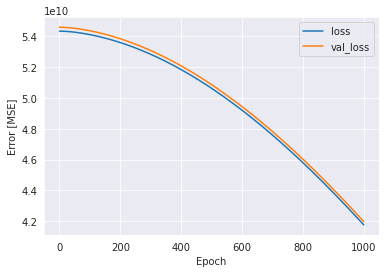

In [110]:
plot_loss(base_history)

Evaluamos la predicción inicial para train

In [111]:
def plot_prices_dist(y_pred, y_pred_test):
    precios_train = pd.concat([y_train, pd.DataFrame(y_pred, columns=['predicted'])], axis=1)
    precios_test = pd.concat([y_test, pd.DataFrame(y_pred_test, columns=['predicted'])], axis=1)
    fig, axs = plt.subplots(1, 3, figsize=(25, 5))

    fig.suptitle("Distribución de precios reales y predichos")

    axs[0].set_xlabel("Precio")
    axs[0].set_ylabel("Densidad")
    axs[0].set_title("Train")
    sns.kdeplot(precios_train['property_price'], ax=axs[0])
    sns.kdeplot(precios_train['predicted'], ax=axs[0])
    axs[0].legend(labels=['Real', 'Predicho'])

    axs[1].set_xlabel("Precio")
    axs[1].set_ylabel("Densidad")
    axs[1].set_title("Test")
    sns.kdeplot(precios_test['property_price'], ax=axs[1])
    sns.kdeplot(precios_test['predicted'], ax=axs[1])
    axs[1].legend(labels=['Real', 'Predicho'])

    axs[2].set_xlabel("Precio Real")
    axs[2].set_ylabel("Precio Predicho")
    axs[2].set_title("Real vs predicho")
    sns.scatterplot(x=precios_train['property_price'], y=precios_train['predicted'], ax=axs[2])
    sns.regplot(x=precios_train['property_price'], y=precios_train['predicted'], scatter=False, ax=axs[2], fit_reg=True, color='darkgreen', ci=0)
    axs[2].legend(labels=['Real', 'Predicho'])

In [112]:
y_pred_base = base_model.predict(x_train_tp1_transform)
y_pred_test_base = base_model.predict(x_test_tp1_transform)

505/505 [==============================] - 0s 601us/step


Metricas Red Neuronal Base - Train
El error (mse) es: 41827883255.392044
El error (rmse) es: 204518.66236456772
El error (r²) es: -0.9340694160043692

Metricas Red Neuronal Base - Test
El error (mse) es: 45749809072.60253
El error (rmse) es: 213892.05004535004
El error (r²) es: -0.9345188117587879



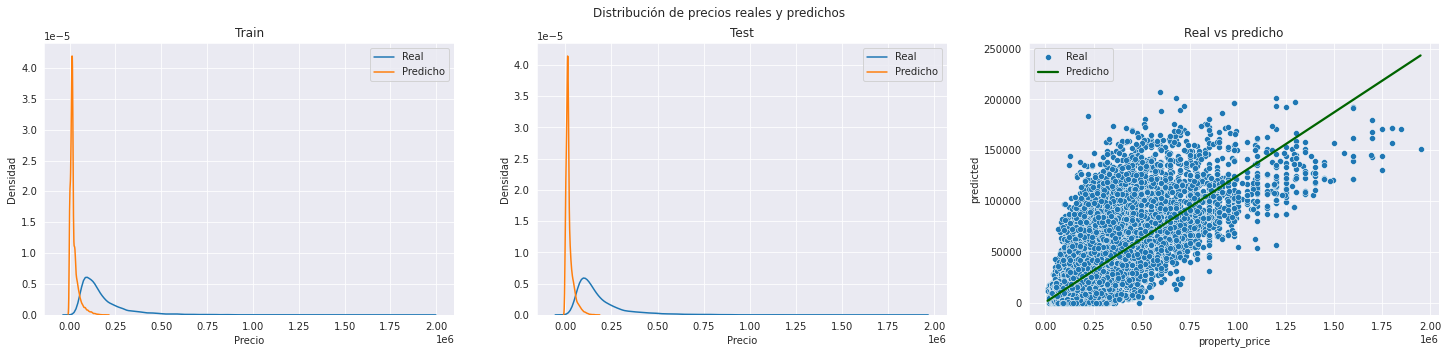

In [113]:
plot_prices_dist(y_pred_base, y_pred_test_base)
regression_metrics("Metricas Red Neuronal Base - Train", y_train, y_pred_base)
regression_metrics("Metricas Red Neuronal Base - Test", y_test, y_pred_test_base)

Vemos que hay mucha dispersión respecto a los precios reales, probaremos un modelo profundo con una capa intermedia con la mitad de las neuronas de la primera.

##### Modelo de 3 capas

In [114]:
def larger_model_builder():
    model = keras.Sequential([
        keras.layers.Dense(d_in, input_shape=(d_in,), kernel_initializer='normal', activation='relu'),
        keras.layers.Dense(int(d_in / 2), kernel_initializer='normal', activation='relu'),
        keras.layers.Dense(1, kernel_initializer='normal', activation='relu')
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [115]:
larger_model_builder().summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
 dense_4 (Dense)             (None, 1)                 5         
                                                                 
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________


In [116]:
larger_model = larger_model_builder()
larger_history = larger_model.fit(
    x_train_tp1_transform,
    y_train,
    epochs=1000,
    batch_size=1000,
    validation_split=0.33,
)

Epoch 1/1000
47/47 [==============================] - 0s 3ms/step - loss: 54341062656.0000 - val_loss: 54593933312.0000
Epoch 2/1000
47/47 [==============================] - 0s 2ms/step - loss: 54341038080.0000 - val_loss: 54593892352.0000
Epoch 3/1000
47/47 [==============================] - 0s 2ms/step - loss: 54340968448.0000 - val_loss: 54593798144.0000
Epoch 4/1000
47/47 [==============================] - 0s 2ms/step - loss: 54340804608.0000 - val_loss: 54593572864.0000
Epoch 5/1000
47/47 [==============================] - 0s 2ms/step - loss: 54340505600.0000 - val_loss: 54593171456.0000
Epoch 6/1000
47/47 [==============================] - 0s 2ms/step - loss: 54340014080.0000 - val_loss: 54592544768.0000
Epoch 7/1000
47/47 [==============================] - 0s 2ms/step - loss: 54339260416.0000 - val_loss: 54591655936.0000
Epoch 8/1000
47/47 [==============================] - 0s 2ms/step - loss: 54338215936.0000 - val_loss: 54590435328.0000
Epoch 9/1000
47/47 [====================

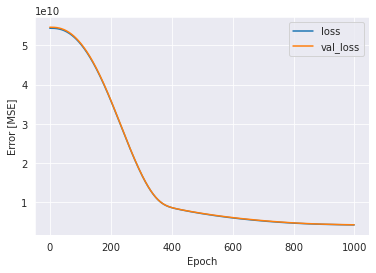

In [117]:
plot_loss(larger_history)

In [120]:
y_pred_larger = larger_model.predict(x_train_tp1_transform)
y_pred_larger_test = larger_model.predict(x_test_tp1_transform)

505/505 [==============================] - 0s 636us/step


Metricas Red Neuronal Profunda - Train
El error (mse) es: 4236475297.7159104
El error (rmse) es: 65088.21166475471
El error (r²) es: 0.8041106394282072

Metricas Red Neuronal Profunda - Test
El error (mse) es: 6093426892.918321
El error (rmse) es: 78060.40541092725
El error (r²) es: 0.7423410241183586



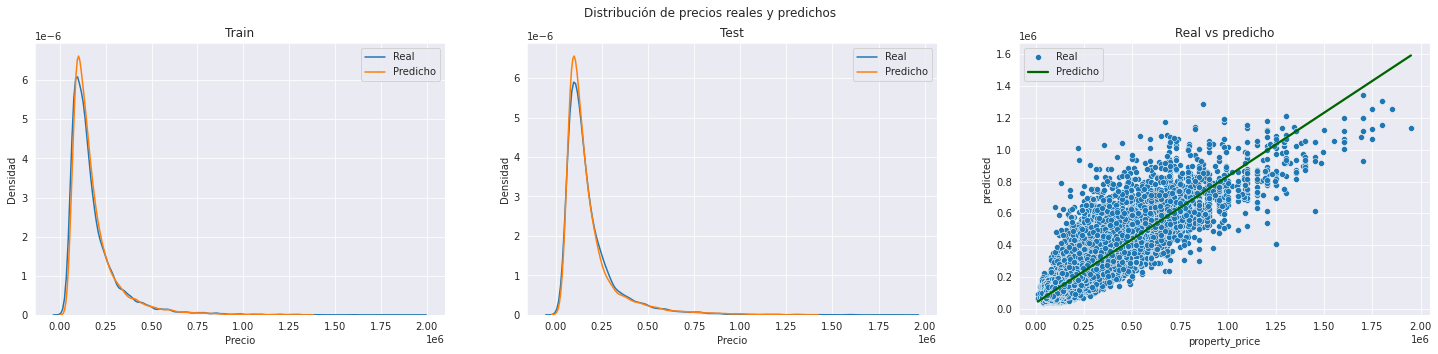

In [121]:
plot_prices_dist(y_pred_larger, y_pred_larger_test)
regression_metrics("Metricas Red Neuronal Profunda - Train", y_train, y_pred_larger)
regression_metrics("Metricas Red Neuronal Profunda - Test", y_test, y_pred_larger_test)

Por último, probaremos un tercer modelo con una capa inical más ancha.

##### Modelo ancho

In [122]:
def wider_model_builder():
    model = keras.Sequential([
        keras.layers.Dense(d_in * 2, input_shape=(d_in,), kernel_initializer='normal', activation='relu'),
        keras.layers.Dense(1, kernel_initializer='normal', activation='relu')
    ])
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [123]:
wider_model_builder().summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 16)                144       
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 161
Trainable params: 161
Non-trainable params: 0
_________________________________________________________________


In [124]:
wider_model = wider_model_builder()
wider_history = wider_model.fit(
    x_train_tp1_transform,
    y_train,
    epochs=1000,
    batch_size=1000,
    validation_split=0.33,
)

Epoch 1/1000
47/47 [==============================] - 0s 3ms/step - loss: 54341025792.0000 - val_loss: 54593884160.0000
Epoch 2/1000
47/47 [==============================] - 0s 2ms/step - loss: 54340911104.0000 - val_loss: 54593667072.0000
Epoch 3/1000
47/47 [==============================] - 0s 2ms/step - loss: 54340579328.0000 - val_loss: 54593212416.0000
Epoch 4/1000
47/47 [==============================] - 0s 2ms/step - loss: 54340014080.0000 - val_loss: 54592512000.0000
Epoch 5/1000
47/47 [==============================] - 0s 2ms/step - loss: 54339182592.0000 - val_loss: 54591553536.0000
Epoch 6/1000
47/47 [==============================] - 0s 2ms/step - loss: 54338129920.0000 - val_loss: 54590373888.0000
Epoch 7/1000
47/47 [==============================] - 0s 2ms/step - loss: 54336831488.0000 - val_loss: 54588973056.0000
Epoch 8/1000
47/47 [==============================] - 0s 2ms/step - loss: 54335324160.0000 - val_loss: 54587342848.0000
Epoch 9/1000
47/47 [====================

In [125]:
y_pred_wider = wider_model.predict(x_train_tp1_transform)
y_pred_wider_test = wider_model.predict(x_test_tp1_transform)

505/505 [==============================] - 0s 599us/step


Metricas Red Neuronal Profunda - Train
El error (mse) es: 19932800820.787445
El error (rmse) es: 141183.57135583248
El error (r²) es: 0.07833202537634709

Metricas Red Neuronal Profunda - Test
El error (mse) es: 23241166528.168423
El error (rmse) es: 152450.5379727091
El error (r²) es: 0.01725330078185472



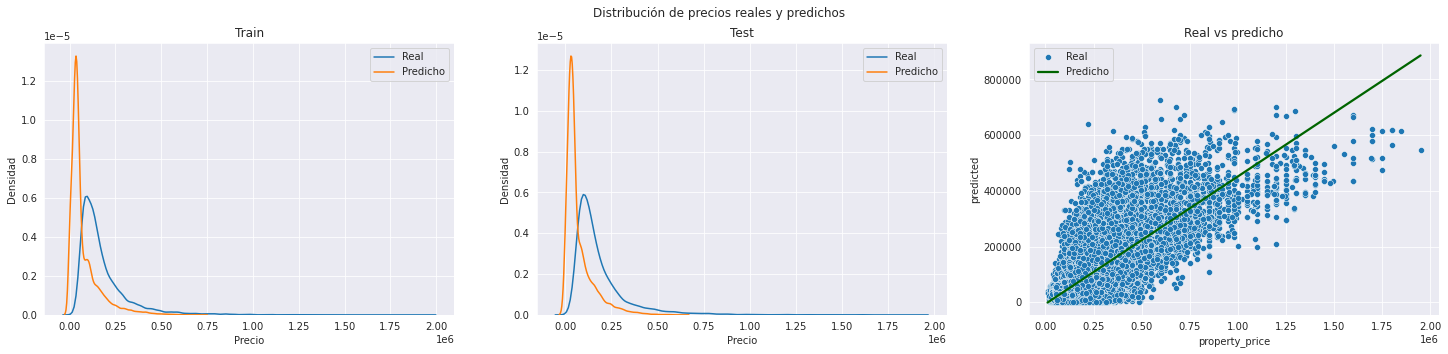

In [126]:
plot_prices_dist(y_pred_wider, y_pred_wider_test)
regression_metrics("Metricas Red Neuronal Profunda - Train", y_train, y_pred_wider)
regression_metrics("Metricas Red Neuronal Profunda - Test", y_test, y_pred_wider_test)

#### Análisis de métricas

Metricas Red Neuronal Profunda - Train
El error (mse) es: 4236475297.7159104
El error (rmse) es: 65088.21166475471
El error (r²) es: 0.8041106394282072

Metricas Red Neuronal Profunda - Test
El error (mse) es: 6093426892.918321
El error (rmse) es: 78060.40541092725
El error (r²) es: 0.7423410241183586



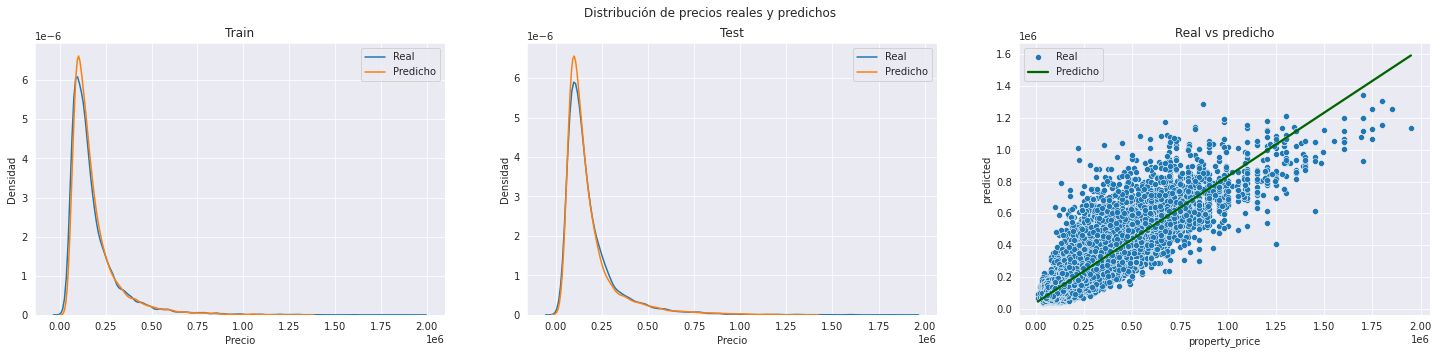

In [127]:
plot_prices_dist(y_pred_larger, y_pred_larger_test)
regression_metrics("Metricas Red Neuronal Profunda - Train", y_train, y_pred_larger)
regression_metrics("Metricas Red Neuronal Profunda - Test", y_test, y_pred_larger_test)

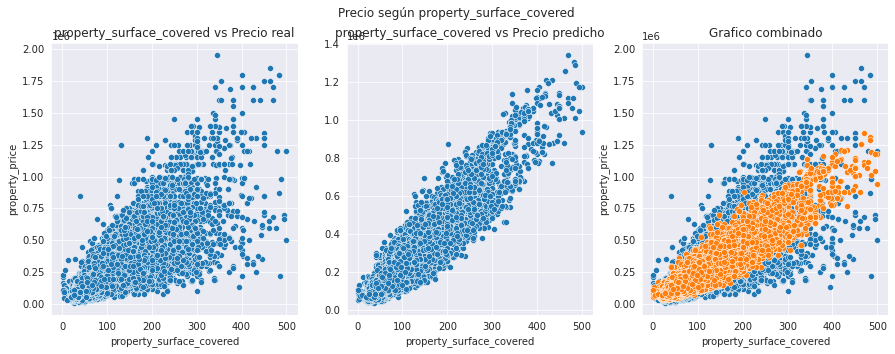

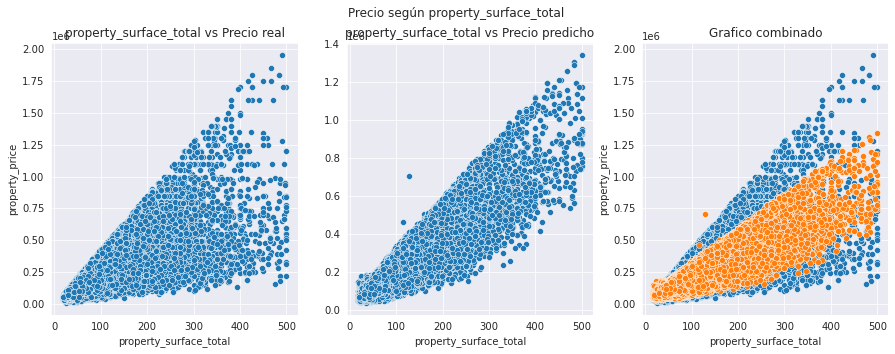

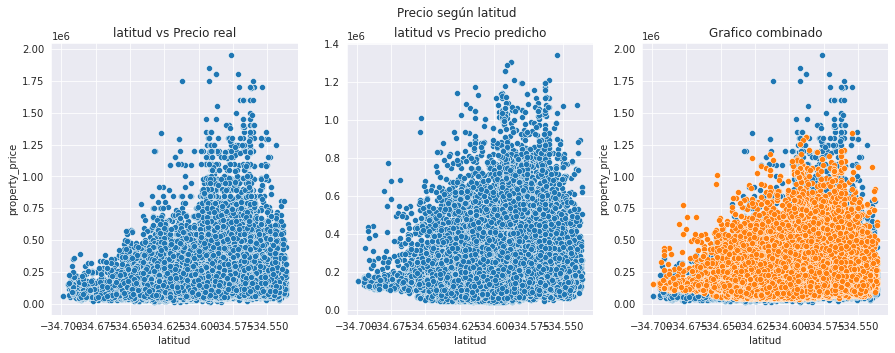

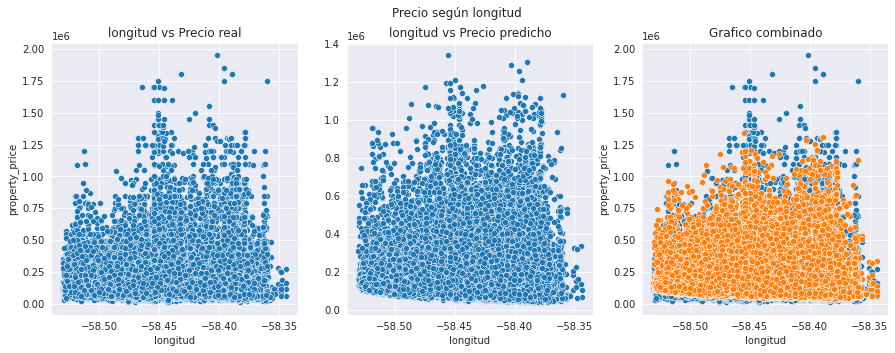

In [128]:
regression_scatter(ds_train.property_surface_covered, y_train, y_pred_larger[:,0])
regression_scatter(ds_train.property_surface_total, y_train, y_pred_larger[:,0])
regression_scatter(ds_train.latitud, y_train,y_pred_larger[:,0])
regression_scatter(ds_train.longitud, y_train,y_pred_larger[:,0])

Podemos ver que las predicciones mejoraron muchísimo y que los precios están cerca de los reales. Sin embargo, falta bastante para llegar a un buen resultado.

###### Cosas a probar para mejorar el modelo:
- Más capas intermedias
- Diferentes funciones de activación
- Usar otro escalado

#### Clasificación

In [129]:
### DS Expandido:

### top3 > % regex -> booleanas
### expensas sacadas con regex --> numerico
### property_desc_score = tecnica chino -> numerico
### serian 5 columnas en total

Otro factor interesante que podriamos analizar es a que tipo de vivienda pertenece cada ammenity. Y si donde encontramos una ammenity en particular, encontramos consecuentemente otra. Por ejemplo, una casa con jardin y parrila y/o pileta.
De esta manera podriamos tratar de determinar el costo de cada ammenity o como afecta al precio.

## Ensambles de modelos

### Ensamble 1

### Ensamble 2

## Conclusiones